# Задание

1) Реализовать стандартную функцию свертки​.
2) Реализовать функцию свертки через im2col.
3) Реализовать Depthwise-separable свертку.

* Специфицировать размер, количество фильтров, входной tensor, stride, padding...
* Придумать тесты для проверки работоспособности всех вариантов свёртки.​

# Настройки/Импорты

In [1]:
import numpy as np # для работы с массивами
import torch # для работы с тензорами
import torch.nn.functional as F # для функций с тензорами
import torchvision.io as tv # для работы с изображениями
from tqdm import tqdm # для отслеживания прогресса
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

# Вспомогательные функции

In [2]:
def show_image(image, figsize: tuple, gray: bool=False) -> None:
    """
    Функция для вывода изображений.\n
    Parameters:
        * image: изображение, что нужно вывести
        * figsize: размер выводимой картинки
        * gray: флаг, является ли изображение одноканальным (чёрно-белым)\n
    Returns:
        * None
    """
    cmap = "gray" if gray else "viridis" # выбор цветовой схемы, (стандартная — "viridis", но если передан ключ gray — "gray")

    plt.figure(figsize=figsize) # размер фигуры
    plt.imshow(image, cmap) # вывод изображения
    plt.show() # показ фигуры

In [3]:
def test_conv(func, input) -> None:
    """
    Функция для тестирования работы свёрток. Сравнивает с реализацией свёрточного слоя на PyTorch при различных параметрах.\n
    Parameters:
        * func: функция свёртки, что нужно протестировать
        * input: входной массив, на котором будет проводиться тестирование (в формате float32) размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)\n 
    Returns:
        * None: выдаст Exception в случае, если есть несовпадение ответов у проверяемой и контрольной функции свёртки
    """
    Channels, H_in, W_in = input.shape # берём значения Channels, Height, Width из входной матрицы

    for Num_filters in tqdm([1, 2]): # рассматриваем возможное число фильтров
        for kernel_size in [1, 2, 3, 5, 7]: # рассматриваем возможные размеры ядер

            W = torch.randint(low=0, high=10, size=(Num_filters, Channels, kernel_size, kernel_size), dtype=torch.float32) # случайно генерируем веса для ядер свёртки (int от 0 до 10 — чтобы решение всегда было точным с последующей конвертацией в float32)
            # размерность W: (число ядер(фильтров) на слое свёртки, Channels — число входных каналов, высота ядра свёртки H_conv, ширина ядра свёртки W_conv)
            b = torch.randint(low=0, high=10, size=(Num_filters,), dtype=torch.float32) # bias по аналогии
            # размерность b: (число ядер(фильтров) на слое свёртки)

            for stride in [1, 2, 5]: # рассматриваем варианты параметра stride
                for padding in [0, 1, 2]: # рассматриваем варианты параметра padding
                    real_conv = torch.nn.Conv2d(in_channels=Channels, out_channels=Num_filters, kernel_size=kernel_size, stride=stride, padding=padding) # слой свёртки из PyTorch
                    real_conv.weight.data = W # меняем веса ядер свёртки на тестируемые (со случайных, заданных при создании Conv2d)
                    real_conv.bias.data = b # меняем bias ядер свёртки на тестируемые (со случайных, заданных при создании Conv2d)
                    
                    res_real = real_conv(input) # считаем результат контрольной свёртки
                    
                    res_func = func(input, W, b, stride, padding) # считаем результат проверяемой свёртки

                    if not torch.equal(res_func, res_real): # сравниваем, что все значения в тензорах одинаковые
                        raise Exception(f"Результат свёрток не совпал при параметрах: Num_filters={Num_filters}, kernel_size={kernel_size}, stride={stride}, padding={padding}") # если есть несовпадения — выкидываем исключение
    print("Все тесты прошли успешно!")

# 1) Реализация стандартной свёртки.

<img src="./images/conv_simple.png" alt="Simple convolution"/>

Функция свёртки:
$$
\mathbf{Out}[id_{conv}][x][y] = \sum_{i=0}^{H_{conv}-1}\sum_{j=0}^{W_{conv}-1}\sum_{c=0}^{Channels-1}\mathbf{Input}[c][Sx+i][Sy+j] * \mathbf{W}[id_{conv}][c][i][j] + \mathbf{b}[id_{conv}]
$$
Где:
* Input — входная матрица размерности (Channels, Height, Width) ~ (Channels, $H_{in}$, $W_{in}$)
* W — матрица весов свёрточного слоя размерности (Num_filters, Channels, $H_{conv}$, $W_{conv}$)
* b — смещения (bias) для вильтров свёртки (одно число на фильтр) размерности (Num_filters)
* Out — выходная матрица (Num_filters, $H_{out}$, $W_{out}$), где $H_{out}$, $W_{out}$ зависят от параметров свёртки
* $id_{conv}$  — номер рассматриваемой свёртки (фильтра свёртки), изменяется от 0 до Num_filters-1
* x — координата **нового** пикселя по вертикали ~ номер строки (в изначальном изображении — Height ~ $H_{in}$)
* y — координата **нового** пикселя по горизонтали ~ номер столбца (в изначальном изображении — Width ~ $W_{in}$)
* $H_{conv}$ — размер ядра свёртки по вертикали (итерируемся с помощью *i*)
* $W_{conv}$ — размер ядра свёртки по горизонтали (итерируемся с помощью *j*)
* Channels — число каналов (фильтров) у входного тензора (итерируемся с помощью *c*)
* S — значение параметра "Stride", отвечающее за размер шага по изображению (смещение по изображению)

In [4]:
def conv_simple(Input, W, b, stride: int=1, padding: int=0) -> torch.Tensor:
    """
    Функция простой свёртки.\n
    Parameters:
        * Input: входной массив размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)
        * W: веса для ядер свёртки
        * b: bias, смещение для фильтра свёртки
        * stride: размер шага по осям (одинаков как для оси OX, так и для OY)
        * padding: значение количества добавляемх "размерностей" по краям входного массива, не включая размерность, отвечающую за каналы (одинаков как для оси OX, так и для OY)\n
    Returns:
        * torch.Tensor: результат применения свёртки
    """
    Channels, H_in, W_in = Input.shape # берём значения Channels, Height, Width из входной матрицы
    Num_filters, Channels, H_conv, W_conv = W.shape # берём значения Num_filters, Channels, H_conv, W_conv из матрицы весов свёртки (Channels должен совпадать с аналогичной размерность из Input)

    Input_padded = F.pad(input=Input, pad=(padding, padding, padding, padding, 0, 0), mode='constant', value=0) # добавляем padding из value на входной массив (0,0 — отвечают за добавляемую размерность в Channels (до и после исходных данных), остальные по аналогии за Width и Height)

    H_out = int((H_in + 2*padding - (H_conv-1) - 1) / stride + 1) # Height выходного тензора
    W_out = int((W_in + 2*padding - (W_conv-1) - 1) / stride + 1) # Width выходного тензора
    Out = torch.zeros(size=(Num_filters, H_out, W_out), dtype=torch.float32) # заготовка под выходной тензор, заполненная нулями
    
    # print(f"Input_padded shape: {Input_padded.shape}")
    # print(f"Out shape: {Out.shape}")

    for id_filter in range(Num_filters): # идём по числу фильтров в одной свёртке (range вернёт список чисел от 0 до Num_filters-1 включительно)
        for x in range(H_out): # идём по пикселям высоты выходного тензора
            for y in range(W_out): # идём по пикселям ширины выходного тензора
#=========================== вариант через медленное сложение всех элементов ========================
                # for i in range(H_conv): # идём по высоте фильтра (ядра) свёртки
                #     for j in range(W_conv): # идём по ширине фильтра (ядра) свёртки
                #         for c in range(Channels): # идём по каналам входного изображения
                #             Out[id_filter][x][y] += Input_padded[c][stride*x + i][stride*y + j] * W [id_filter][c][i][j]
#--------------------------- вариант через быстрое перемножение тензоров ----------------------------
                H_from, H_to = stride*x, stride*x+H_conv # с какого пикселя по какой смотреть на входном изображении по вертикали
                W_from, W_to = stride*y, stride*y+W_conv # с какого пикселя по какой смотреть на входном изображении по горизонтали
                Out[id_filter][x][y] = torch.sum(Input_padded[:, H_from:H_to, W_from:W_to] * W[id_filter]) # перемножаем матрицы Input_padded в нужной области и W поэлементно (у них должна быть одинаковая размерность) и складываем все элементы получившейся матрицы
#====================================================================================================
                Out[id_filter][x][y] += b[id_filter] # добавляем смещение фильтра (bias)
                            
    return Out # возвращаем полученный массив

# 2) Реализация свёртки через im2col.

<img src="./images/im2col_conv.png" alt="im2col convolution"/>

In [5]:
def conv_im2col(Input, W, b, stride: int=1, padding: int=0, conv_back: bool=True) -> torch.Tensor:
    """
    Функция свёртки через im2col.\n
    Parameters:
        * Input: входной массив размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)
        * W: веса для ядер свёртки
        * b: bias, смещение для фильтра свёртки
        * stride: размер шага по осям (одинаков как для оси OX, так и для OY)
        * padding: значение количества добавляемх "размерностей" по краям входного массива, не включая размерность, отвечающую за каналы (одинаков как для оси OX, так и для OY)
        * conv_back: флаг, нужно ли делать обратную конвертацию из 2d тензора (Num_filters, H_out*W_out) в 3d тензор (Num_filters, H_out, W_out)\n
    Returns:
        * torch.Tensor: результат применения свёртки
    """
    Channels, H_in, W_in = Input.shape # берём значения Channels, Height, Width из входной матрицы
    Num_filters, Channels, H_conv, W_conv = W.shape # берём значения Num_filters, Channels, H_conv, W_conv из матрицы весов свёртки (Channels должен совпадать с аналогичной размерность из Input)

    Input_padded = F.pad(input=Input, pad=(padding, padding, padding, padding, 0, 0), mode='constant', value=0) # добавляем padding из value на входной массив (0,0 — отвечают за добавляемую размерность в Channels (до и после исходных данных), остальные по аналогии за Width и Height)

    H_out = int((H_in + 2*padding - (H_conv-1) - 1) / stride + 1) # Height выходного тензора
    W_out = int((W_in + 2*padding - (W_conv-1) - 1) / stride + 1) # Width выходного тензора

    # уменьшаем размерность матриц до 2d
    Input_2d = torch.zeros(size=(H_conv*W_conv*Channels, H_out*W_out), dtype=torch.float32) # входной массив, преобразованный из 3d в 2d размерности (H_conv*W_conv*Channels, H_out*W_out)
    for patch_id in range(H_out*W_out): # идём по столбцам 2d тензора входа (Patch_ам)
        x = patch_id % W_out # номер рассматриваемой строки
        H_from, H_to = stride*x, stride*x+H_conv # с какого пикселя по какой смотреть на входном изображении по вертикали
        y = patch_id // W_out # номер рассматриваемого столбца
        W_from, W_to = stride*y, stride*y+W_conv # с какого пикселя по какой смотреть на входном изображении по горизонтали
        Input_2d[:, patch_id] = Input_padded[:, H_from:H_to, W_from:W_to].flatten() # записываем значение в колонку (flatten "расправляет" все элементы массива в вектор)
    
    W_2d = torch.zeros(size=(Num_filters, H_conv*W_conv*Channels), dtype=torch.float32) # фильтры, объединённые в двумерный тензор (из 3d в 2d) размерности (Num_filters, H_conv*W_conv*Channels)
    for id_filter in range(Num_filters): # идём по строкам 2d тензора весов ядер (индексам фильтров в свёрточном слое)
        W_2d[id_filter] = W[id_filter].flatten() # записываем значение в строку (flatten "расправляет" все элементы массива в вектор)

    Out = W_2d @ Input_2d # перемножаем матрицы строку на столбец (@ — аналог torch.matmul)
    for id_filter in range(Num_filters): # идём по строкам выходного тензора
        Out[id_filter] += b[id_filter] # добавляем смещение фильтра (bias)

    if conv_back: # если стоит флаг обратной конвертации
        Out = Out.reshape(Num_filters, H_out, W_out) # приводим обратно к 3d тензору размерности (Num_filters, H_out, W_out)
        Out = Out.transpose(1, 2) # транспонируем оси 1 и 2, так как тензор после reshape получается повёрнутым (0 ~ Num_filters ~ Channels не меняются, а Height и Width транспонируются)
    return Out # возвращаем полученный массив

# 3) Реализация Depthwise-separable свёртки

# Тестирование

Берём произвольное изображение (можно даже сгенерировать случайную матрицу) в формате torch.Tensor.

In [6]:
Input = tv.read_image('./data/bird_25x25.png') # считываем изображение; в Torch изображения идут сразу в формате RGB, но в виде (Channels, Height, Width)
Input.shape # изначальная размерность изображения

torch.Size([3, 25, 25])

Пример визуализации изображения.

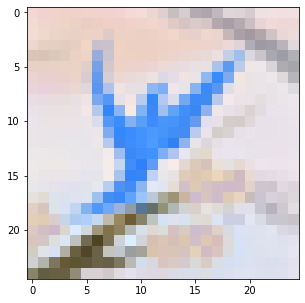

In [7]:
Input_show = Input.permute((1, 2, 0)) # приводим к формату, воспринимаемому в matplotlib, то есть меняем местами размерности: (Channels, Height, Width) => (Height, Width, Channels)
Input_show.shape # размерность для matplotlib
show_image(image=Input_show, figsize=(5, 5)) # вывод изображения

Конвертируем изображение в float32.

In [8]:
Input = Input.to(torch.float32) # переводим изначальный tensor из int8 в float32
print(Input)

tensor([[[243., 241., 240.,  ..., 241., 241., 241.],
         [242., 239., 238.,  ..., 239., 237., 237.],
         [241., 240., 237.,  ..., 209., 233., 235.],
         ...,
         [207., 224., 215.,  ..., 221., 222., 228.],
         [207., 179., 126.,  ..., 218., 221., 227.],
         [136.,  99., 103.,  ..., 220., 222., 228.]],

        [[215., 210., 211.,  ..., 225., 224., 225.],
         [219., 213., 212.,  ..., 218., 215., 216.],
         [221., 216., 212.,  ..., 194., 215., 220.],
         ...,
         [205., 227., 225.,  ..., 226., 226., 229.],
         [208., 179., 119.,  ..., 223., 223., 225.],
         [132.,  93.,  96.,  ..., 224., 224., 227.]],

        [[212., 206., 203.,  ..., 226., 226., 227.],
         [210., 205., 201.,  ..., 216., 215., 215.],
         [210., 205., 201.,  ..., 195., 214., 217.],
         ...,
         [196., 232., 243.,  ..., 239., 239., 240.],
         [212., 174.,  96.,  ..., 238., 238., 236.],
         [108.,  67.,  67.,  ..., 238., 239., 238.]]]

## Вариант 1:

In [9]:
test_conv(conv_simple, Input) # запускаем тестирование функции свёртки

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.19s/it]

Все тесты прошли успешно!


## Вариант 2:

In [10]:
test_conv(conv_im2col, Input) # запускаем тестирование функции свёртки

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

Все тесты прошли успешно!


## Вариант 3:

# Общее

In [137]:
stride = 2
padding = 1
Num_filters = 2

Channels, H_in, W_in = 3, 5, 5
Channels, H_conv, W_conv = 3, 3, 3

# x = torch.ones(3, 5, 5)
Input = torch.torch.randint(low=0, high=9, size=(Channels, H_in, W_in), dtype=torch.float32)
Input_padded = F.pad(input=Input, pad=(padding, padding, padding, padding, 0, 0), mode='constant', value=0) # добавляем padding из value на входной массив (0,0 — отвечают за добавляемую размерность в Channels (до и после исходных данных), остальные по аналогии за Width и Height)

H_out = int((H_in + 2*padding - (H_conv-1) - 1) / stride + 1) # Height выходного тензора
W_out = int((W_in + 2*padding - (W_conv-1) - 1) / stride + 1) # Width выходного тензора

# W = torch.ones(3, 5, 5)
# W = torch.full((Channels, H_conv, W_conv), 2)
W = torch.randint(low=0, high=10, size=(Num_filters, Channels, H_conv, W_conv), dtype=torch.float32)

b = torch.randint(low=0, high=10, size=(Num_filters,), dtype=torch.float32) # bias по аналогии

In [138]:
Input_padded

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 4., 5., 1., 2., 0.],
         [0., 8., 4., 6., 8., 1., 0.],
         [0., 5., 2., 3., 7., 0., 0.],
         [0., 6., 5., 4., 5., 1., 0.],
         [0., 3., 0., 3., 6., 3., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 3., 4., 8., 0.],
         [0., 5., 4., 2., 2., 5., 0.],
         [0., 5., 2., 2., 1., 5., 0.],
         [0., 5., 2., 1., 3., 4., 0.],
         [0., 7., 7., 5., 8., 4., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 2., 8., 8., 4., 0.],
         [0., 3., 5., 7., 3., 5., 0.],
         [0., 6., 5., 0., 3., 7., 0.],
         [0., 7., 3., 0., 1., 3., 0.],
         [0., 8., 8., 3., 2., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

# 

In [125]:
Input = tv.read_image('./data/bird_256x256.png') # считываем изображение; в Torch изображения идут сразу в формате RGB, но в виде (Channels, Height, Width)
Input = Input.to(torch.float32) # переводим int8 в float32

# W = torch.ones((2, 3, 3, 3), dtype=torch.float32) # веса для ядер свёртки
# b = torch.ones((2), dtype=torch.float32) # bias

# W = torch.rand((2, 3, 3, 3), dtype=torch.float32) # веса для ядер свёртки
# b = torch.rand((2), dtype=torch.float32) # bias

W = torch.randint(low=0, high=10, size=(2, 3, 3, 3), dtype=torch.float32) # веса для ядер свёртки
b = torch.randint(low=0, high=10, size=(2,), dtype=torch.float32) # bias

In [126]:
res = conv_im2col(Input, W, b)

In [127]:
res

tensor([[28101., 28205., 28310.,  ..., 29422., 29397., 29384.],
        [20621., 20693., 20786.,  ..., 21809., 21789., 21779.]])

In [150]:
m = torch.nn.Conv2d(Channels, Num_filters, kernel_size=3, stride=stride, padding=padding)
m.bias.data = b
m.weight.data = W

res_ = m(Input.to(torch.float32))

In [129]:
torch.equal(res_, res)

False

In [130]:
res_

tensor([[[12733., 19586., 19620.,  ..., 20875., 20831., 20874.],
         [19474., 28173., 28183.,  ..., 29747., 29688., 29750.],
         [19574., 28400., 28373.,  ..., 29554., 29444., 29420.],
         ...,
         [ 8347., 11862., 11936.,  ..., 29458., 29450., 29466.],
         [ 8221., 12232., 12514.,  ..., 29427., 29412., 29422.],
         [ 8694., 12481., 12107.,  ..., 29434., 29404., 29384.]],

        [[ 9721., 12239., 12268.,  ..., 13067., 13039., 13072.],
         [14904., 20660., 20659.,  ..., 21926., 21877., 21918.],
         [14997., 20841., 20819.,  ..., 21801., 21711., 21698.],
         ...,
         [ 6313.,  8599.,  8610.,  ..., 21834., 21819., 21833.],
         [ 6282.,  8838.,  9031.,  ..., 21818., 21803., 21809.],
         [ 6673.,  9006.,  8821.,  ..., 21827., 21790., 21779.]]],
       grad_fn=<SqueezeBackward1>)

In [121]:
res

tensor([[494., 487., 441., 487., 511., 402., 471., 358., 398.],
        [479., 500., 451., 513., 427., 362., 466., 307., 344.],
        [517., 516., 409., 458., 446., 420., 451., 397., 431.],
        [502., 538., 529., 442., 502., 387., 401., 389., 341.],
        [571., 510., 530., 528., 485., 388., 520., 362., 440.]])